### Validation of speech detection by GPT4o.

This notebook tests the performance of our pipeline in identifying sentences that contain sections of direct speech.

#### For each sentence we want to know:
* is it direct speech
* is it indirect speech
* is it contained in the GPT4o-identified speech sections for this book
* is it junk (i.e. non-sentence text introduced by pdfplumber)  

In [1]:
VALIDATION_RUN_NAME = 'CM_SPEECH_DETECTION_VALIDATION_NEWRUN_190924'

In [2]:
import pandas as pd
import json
import spacy
import pickle
import string

from IPython.display import display, Markdown, clear_output
from ipywidgets.widgets import Button, Layout, ButtonStyle, GridBox
from ipywidgets import widgets
from random import randint

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
with open('data/tempdf.pickle', 'rb') as outfile:
    df = pickle.load(outfile)

In [5]:
with open('data/gpt4_speakers_recipients_processed.json', 'r') as outfile:
    speakers = pd.read_json(outfile)

In [6]:
from openai_api.utilities import spacy_extract_sentences
sentences = spacy_extract_sentences(df, nlp)

In [7]:
remove_non_stories = [
    'All Year Round', 'All About Feelings', 'Ten in the Bed and Other Counting Rhymes', 
    'Why Am I An Insect',
    'How The Grinch Stole Christmas', 
    'Farmer Duck'
]

In [8]:
sentences = sentences[~sentences.book.isin(remove_non_stories)]

In [9]:
validation_sample = sentences.sample(1000, random_state=42, replace=False)

In [10]:
validation_sample = validation_sample[~validation_sample.book.isin(remove_non_stories)]

In [11]:
sample_index_iterator = iter(validation_sample.index)

In [12]:
SID = []
DS = []
IDS = []
FOUND = []
JUNK = []

In [13]:
def next_sample(arg, _sample_index_iterator=sample_index_iterator, delta=20):
    
    clear_output(wait=True)
    make_next()
    
    for l in [DS, IDS, FOUND, JUNK]:
        if len(l) < len(SID):
            l.append(0)
    
    sample_id = next(_sample_index_iterator)
    sample = validation_sample.loc[sample_id]
    SID.append(sample_id)
    
    print(f"Book: {sample.book}")
    print(f"Sentence:  {sample.sentence.text}")
    sentence_set = set(sample.sentence.text.split())
    print('In context: \n')
    
    start = sample.sentence.start
    end = sample.sentence.end
    text = df[df.Title == sample.book].iloc[0].Text.replace('\n', ' ').replace('\t', ' ')
    text = ' '.join(text.split())
    doc = nlp(text)
    
    _delta_s = min(delta, start)
    _delta_e = min(delta, len(doc)-end)
    display(
        Markdown(
            doc[start-_delta_s:start].text 
            + f" **{doc[start:end]}** "
            + doc[end:end + _delta_e].text
        )
    )
    print('***********************************')
    
    book_sections = speakers[speakers.book == sample.book].speech_text
    
    matched_sentences = {
        'sid': [],
        'text': [],
        'overlap': []
    }
    # Reproduce sentence set without any dodgy punctuation:
    sentence_set = set(
        sample.sentence.text.translate(str.maketrans('', '', string.punctuation)).replace('“', '').replace('”', '').split()
    )

    for si, section in book_sections.items():
        overlap = len(sentence_set.intersection(set(
            section.translate(str.maketrans('', '', string.punctuation)).replace('“', '').replace('”', '').split()
        )))
        if overlap > 0:
            matched_sentences['sid'].append(si)
            matched_sentences['text'].append(section)
            matched_sentences['overlap'].append(overlap)
    
    matched_sentences = pd.DataFrame(matched_sentences)  
    matched_sentences.sort_values('overlap', ascending=False, inplace=True)
    for i,row in matched_sentences.iterrows():
        print(i, row.text, '\n')
    
    with open(f"./results/{VALIDATION_RUN_NAME}.pickle", 'wb') as outfile:
        pickle.dump(
            {
                'SID': SID,
                'DIRECT_SPEECH':DS,
                'INDIRECT_SPEECH':IDS,
                'FOUND':FOUND,
                'JUNK':JUNK,
            }, 
            outfile
        )
    

In [14]:
def make_next():
    next_button = widgets.Button(description = 'Next example.')   
    next_button.on_click(next_sample)
    display(next_button)
    
def is_ds(arg):
    DS.append(1)
def is_ids(arg):
    IDS.append(1)
def is_found(arg):
    FOUND.append(1)
def is_junk(arg):
    JUNK.append(1)
    
def make_controls():
    ds_button = widgets.Button(description = 'Is direct speech?')   
    ds_button.on_click(is_ds)
    display(ds_button)
    
    ids_button = widgets.Button(description = 'Is indirect speech?')   
    ids_button.on_click(is_ids)
    display(ids_button)
    
    found_button = widgets.Button(description = 'Is in GPT4o output?')   
    found_button.on_click(is_found)
    display(found_button)
    
    junk_button = widgets.Button(description = 'Is junk?')   
    junk_button.on_click(is_junk)
    display(junk_button)

In [15]:
make_controls()

Button(description='Is direct speech?', style=ButtonStyle())

Button(description='Is indirect speech?', style=ButtonStyle())

Button(description='Is in GPT4o output?', style=ButtonStyle())

Button(description='Is junk?', style=ButtonStyle())

In [16]:
make_next()

Button(description='Next example.', style=ButtonStyle())

Book: Shark In The Dark
Sentence:  Could it be a GREAT WHITE SHARK?
In context: 



everywhere. And this is what he sees. Stumbling starfish! What’s that swishing through the dark? **Could it be a GREAT WHITE SHARK?** Tim says “Silly me! It’s a seagull with his tea!” Timothy Pope, Timothy Pope

***********************************
0 Silly me!
It’s a seagull with his
tea! 



In [70]:
test_results = pd.DataFrame({
    'SID': SID[:-1],
    'DIRECT_SPEECH':DS,
    'INDIRECT_SPEECH':IDS,
    'FOUND':FOUND,
    'JUNK':JUNK,
})
test_results.to_json(f"./results/{VALIDATION_RUN_NAME}.json")

print(
    "Sensitivity: ",
    test_results[test_results.DIRECT_SPEECH==1].FOUND.sum() / len(test_results[test_results.DIRECT_SPEECH==1])
)
print(
    "FPR: ",
    test_results[test_results.DIRECT_SPEECH==0].FOUND.sum() / len(test_results[test_results.DIRECT_SPEECH==0]))

print(
    "Indirect found: ",
    test_results[test_results.INDIRECT_SPEECH==1].FOUND.sum() / len(test_results[test_results.INDIRECT_SPEECH==1])
)
print(
    "Indirect: ",
    (test_results.INDIRECT_SPEECH==1).sum() / len(test_results)
)

Sensitivity:  0.9558823529411765
FPR:  0.007936507936507936
Indirect found:  0.25
Indirect:  0.012307692307692308


In [71]:
len(DS)

650

In [72]:
len(test_results)

650

In [491]:
# print(DS, IDS, FOUND, JUNK)

#### Notes: 
* Farmer Duck (and other books) were not included in the latets GPT4o run. Do a few extra sample and remove these ones afterwards.
* Including ambiguous speech in indirect speech?
* The Troll seems to be missing some speech sections?
* Comment on narrator to reader (Mind your manners, going on a bear hunt, book with no pictures, Bottoms Up, Open Very Carefully, A Book With Bite!.., e.g. Same but different not identified by GPT4o but should be?)... (comment on letters/notes?)
* Redo analysis without narrator to reader?
* The Christmas Extravaganza Hotel: missing " speech mark before "A supersonic..."
* She Rex issue with text not being visible when convert to pdf! (how common is this?)
* At least one case where "he thought" not included as direct speech (Super Sid Silly Sausage) 

In [458]:
len(sentences) *0.05

647.5500000000001

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, classification_report
import pickle

In [27]:
# with open(f"./results/{VALIDATION_RUN_NAME}.pickle", 'rb') as infile:
#         validation_results = pickle.load(infile)

In [30]:
with open(f"./results/{VALIDATION_RUN_NAME}.json", 'r') as infile:
    test_results = pd.read_json(infile)

In [31]:
test_results

,SID,DIRECT_SPEECH,INDIRECT_SPEECH,FOUND,JUNK
0,2323,0,0,0,0
1,9022,1,0,1,0
2,828,0,0,0,0
3,13056,0,0,0,0
4,4687,0,0,0,0
...,...,...,...,...,...
645,8591,0,0,0,0
646,9220,1,0,1,0
647,7871,0,0,0,0
648,10490,1,0,1,0


In [32]:
cm = confusion_matrix(test_results.DIRECT_SPEECH, test_results.FOUND)

In [33]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['not speech', 'speech']
)

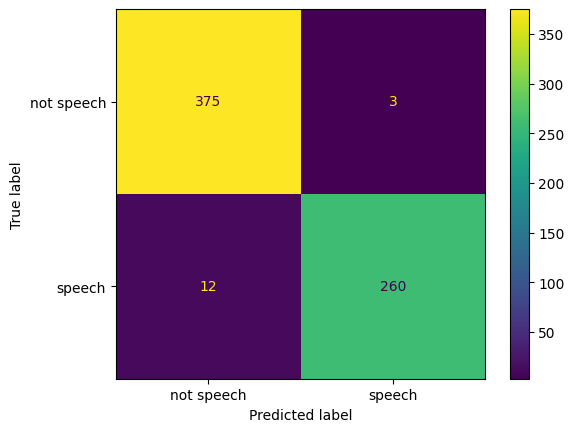

In [34]:
disp.plot();

In [35]:
y_true = test_results.DIRECT_SPEECH
y_pred = test_results.FOUND

print(
    accuracy_score(y_true, y_pred), 
    f1_score(y_true, y_pred), 
    recall_score(y_true, y_pred), 
    precision_score(y_true, y_pred)
)

0.9769230769230769 0.9719626168224298 0.9558823529411765 0.9885931558935361


In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       378
           1       0.99      0.96      0.97       272

    accuracy                           0.98       650
   macro avg       0.98      0.97      0.98       650
weighted avg       0.98      0.98      0.98       650



In [69]:
21/200

0.105

In [50]:
len(test_results)


650

In [52]:
test_results.FOUND.sum() / len(test_results)

0.4046153846153846

In [37]:
test_results.JUNK.sum()

4

In [55]:
test_results.DIRECT_SPEECH.sum() 

272

In [39]:
100 * test_results.INDIRECT_SPEECH.sum() / len(test_results)

1.2307692307692308

In [40]:
100 * test_results.DIRECT_SPEECH.sum() / len(test_results)

41.84615384615385

In [57]:
260/272

0.9558823529411765

In [47]:
100 * test_results[test_results.DIRECT_SPEECH==1].FOUND.sum() / len(test_results[test_results.DIRECT_SPEECH==1])

95.58823529411765

In [58]:
test_results[test_results.INDIRECT_SPEECH==1].FOUND.sum()

2

In [45]:
test_results[test_results.INDIRECT_SPEECH==1].FOUND.sum() / len(test_results[test_results.INDIRECT_SPEECH==1])

0.25

In [63]:
370/650

0.5692307692307692

In [67]:
len(test_results[(test_results.DIRECT_SPEECH==0) * ((test_results.INDIRECT_SPEECH==0))])

370

In [66]:
test_results[(test_results.DIRECT_SPEECH==0) * ((test_results.INDIRECT_SPEECH==0))].FOUND.sum()

1

In [65]:
100 * test_results[(test_results.DIRECT_SPEECH==0) * ((test_results.INDIRECT_SPEECH==0))].FOUND.sum() / len(test_results[(test_results.DIRECT_SPEECH==0) * ((test_results.INDIRECT_SPEECH==0))])

0.2702702702702703